# HW4 - Evaluation measures and logistic regression

## Task 1: Evaluation measures (2 points)

This task is built around the banknote authentication dataset. These data were extracted from images that were taken for the evaluation of an authentication procedure for banknotes. Original dataset has 5 features but we have decided to keep only 2, in order to make the classification task harder. There are two classes in this task: forged (1) and genuine (0). See more details about the data at https://archive.ics.uci.edu/ml/datasets/banknote+authentication .

In [10]:
import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, \
                            f1_score, roc_curve, confusion_matrix

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from IPython.display import display

In [11]:
df = pd.read_csv('data_banknote_authentication.txt', header = None, names=['variance','skewness','curtosis','entropy','y'])
df = df.drop(columns=['skewness','variance']) # We'll remove these two columns to make the task harder
pd.set_option('max_rows', 10)
display(df)

curtosis  entropy  y
0      -2.8073 -0.44699  0
1      -2.4586 -1.46210  0
2       1.9242  0.10645  0
3      -4.0112 -3.59440  0
4       4.5718 -0.98880  0
...        ...      ... ..
1367   -1.4501 -0.55949  1
1368    6.4774  0.34179  1
1369   17.5932 -2.77710  1
1370   12.3930 -1.28230  1
1371    2.6842  1.19520  1

[1372 rows x 3 columns]

In [12]:
sns.scatterplot(df['curtosis'],df['entropy'],hue=df['y'])
plt.show()

AttributeError: module 'seaborn' has no attribute 'scatterplot'

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('y', axis=1), df.y, 
                                                    train_size=0.7, test_size=0.3, 
                                                    random_state=0, shuffle=True, stratify=df.y)
X_train.shape, X_test.shape

((960, 2), (412, 2))

Now we will train and evaluate several classifiers. We will tune them as well in order to find optimal parameters and achieve  the best possible performance.

Every `sklearn` classifier has a set of tuneable parameters, you can check the list of defaults parameters like that:

In [14]:
knn = KNeighborsClassifier()
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': 1,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

For the parameter tuning you can use Grid Search (check every possible combination of parameters from the predefined dictionary). Let us see what parameter values it found as best:

In [15]:
knn_param_grid = {
    'weights':['uniform', 'distance'],
    'n_neighbors': [1, 3, 5, 10, 15, 20, 30, 100]
}

knn_grid_search = GridSearchCV(knn, knn_param_grid, cv=3, return_train_score=True)
knn_grid_search.fit(X_train, y_train)
knn_grid_search.best_params_

{'n_neighbors': 1, 'weights': 'uniform'}

- **(a)** On the test set calculate the accuracy of the KNN model with default parameters and with the parameters selected by cross-validation. Which is better and why?

In [16]:
knn_default = KNeighborsClassifier()
knn_default.fit(X_train,y_train)
dp=knn_default.predict(X_test)
best_knn=KNeighborsClassifier(n_neighbors = 1, weights = 'uniform')
best_knn.fit(X_train,y_train)
bp=best_knn.predict(X_test)
knn_grid_search_predictions = knn_grid_search.predict(X_test)
print ("KNN test accuracy with default parameters:",accuracy_score(y_test,dp))
print ("KNN test accuracy after parameter tuning :",accuracy_score(y_test,bp))
# print('KNN test accuracy with default parameters:',knn_default_test_accuracy)
# print('KNN test accuracy after parameter tuning :',knn_tuned_test_accuracy)

KNN test accuracy with default parameters: 0.7257281553398058
KNN test accuracy after parameter tuning : 0.6820388349514563


**<font color='purple'>Answer to (a):</font>** The accuracy of the KNN model with default parameters is better then the parameters selected by cross-validation. Although tuning has best fit parameters yet data is too noisy. I consider default parameters has more accuracy because n_neighbour is 5 and after parameter tuning its 1. 

- **(b)** Look at the detailed results of cross-validation as printed below. The columns ending with '_time' are about running time, but please describe the meaning of other columns.

In [17]:
knn_cv_results = pd.DataFrame(knn_grid_search.cv_results_)
knn_cv_results.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.000332      0.000469         0.003874        0.002854   
1       0.000000      0.000000         0.000000        0.000000   
2       0.000000      0.000000         0.000000        0.000000   
3       0.002790      0.002466         0.001305        0.001209   
4       0.000334      0.000472         0.002705        0.003825   

  param_n_neighbors param_weights                                     params  \
0                 1       uniform   {'n_neighbors': 1, 'weights': 'uniform'}   
1                 1      distance  {'n_neighbors': 1, 'weights': 'distance'}   
2                 3       uniform   {'n_neighbors': 3, 'weights': 'uniform'}   
3                 3      distance  {'n_neighbors': 3, 'weights': 'distance'}   
4                 5       uniform   {'n_neighbors': 5, 'weights': 'uniform'}   

   split0_test_score  split1_test_score  split2_test_score  mean_test_score  \
0           0.704050           0.731250           0.699060         0.711458   
1           0.704050           0.731250           0.699060         0.711458   
2           0.704050           0.681250           0.699060         0.694792   
3           0.669782           0.684375           0.705329         0.686458   
4           0.685358           0.653125           0.686520         0.675000   

   std_test_score  rank_test_score  split0_train_score  split1_train_score  \
0        0.014142                1            1.000000            1.000000   
1        0.014142                1            1.000000            1.000000   
2        0.009790                8            0.866980            0.853125   
3        0.014587               12            1.000000            1.000000   
4        0.015475               14            0.813772            0.796875   

   split2_train_score  mean_train_score  std_train_score  
0            1.000000          1.000000         0.000000  
1            1.000000          1.000000         0.000000  
2            0.861154          0.860420         0.005680  
3            1.000000          1.000000         0.000000  
4            0.811232          0.807293         0.007439

**<font color='purple'>Answer to (b):</font>**
The columns 'param_n_neighbors', 'param_weights' and 'params' are about number of neighbors, types of parameters weights and their combination respectively. Score splits into three test and train scores name as split0_test_score, split1_test_score and split2_test_score for test and split0_train_score, split1_train_score and split2_train_score for train. The columns mean_test_score and mean_train_score is representing mean of all the test_scores and train scores.The columns std_test_score and std_train_score are the standard mean of test score and training score.The column rank_test_score is highest of split score.

<font color='red'>Note that the column names involving the word 'test' might be a bit confusing - they are referring to the test fold within cross-validation, which perhaps could be better called a validation fold. Therefore, the accuracies in this table are also potentially different from what you found in subtask (b).</font>

Let us now keep only some of the columns which are the most relevant for our purpose. Also, let us sort the results by mean_test_score.

In [18]:
def cv_column_filter(df):
    return(df.loc[:,[c for c in df.columns 
                     if (c[:11]=='mean_train_') or 
                        (c[:10]=='mean_test_') or 
                        (c[:6]=='param_')]])

knn_cv_results = cv_column_filter(knn_cv_results)
knn_cv_results = knn_cv_results.sort_values('mean_test_score',ascending=False)
pd.set_option('max_rows', 20)
knn_cv_results

param_n_neighbors param_weights  mean_test_score  mean_train_score
0                  1       uniform         0.711458          1.000000
1                  1      distance         0.711458          1.000000
11                20      distance         0.709375          1.000000
7                 10      distance         0.704167          1.000000
9                 15      distance         0.703125          1.000000
13                30      distance         0.703125          1.000000
15               100      distance         0.703125          1.000000
2                  3       uniform         0.694792          0.860420
5                  5      distance         0.688542          1.000000
6                 10       uniform         0.688542          0.764061
8                 15       uniform         0.688542          0.736967
3                  3      distance         0.686458          1.000000
10                20       uniform         0.677083          0.702064
4                  5       uniform         0.675000          0.807293
12                30       uniform         0.673958          0.684888
14               100       uniform         0.603125          0.609365

- **(c)** Looking at the above table, are both parameters important factors for the performance of KNN? Generally, is more or less neighbours good in this task? Is uniform or distance-based weighting better in this task?

**<font color='purple'>Answer to (c):</font>** Both parameters are important factors for the performance of KNN.when neighbors count is increse then accuracy is also increaseing but for a certain number of neighbors mean test score is decreasing for instance 100. the examine reaveled that for param_n_neighbors=20 mean_test_score is 0.709375 and 0.677083 in distance and uniform respectvely.
So distance-based is weighting better in this task.

- **(d)** Let us now wrap up parameter tuning process into a single function, which would later work for other types of models as well, not just KNN models. Compare the displayed table to knn_cv_results above and explain the meaning of extra columns.

In [19]:
def tune_model(model, param_grid, X_train=X_train, y_train=y_train, cv=5, max_rows=10):
    grid_search = GridSearchCV(model, param_grid, cv=cv, return_train_score=True, scoring=['accuracy','f1','roc_auc'],refit='accuracy')
    grid_search.fit(X_train, y_train)
    cv_results = pd.DataFrame(grid_search.cv_results_)
    cv_results = cv_column_filter(cv_results)
    cv_results = cv_results.sort_values('mean_test_accuracy',ascending=False)
    pd.set_option('max_rows',max_rows)
    display(cv_results)
    pd.reset_option('max_rows')
    return(grid_search)

In [20]:
knn = KNeighborsClassifier()
knn_param_grid = {
    'weights':['uniform', 'distance'],
    'n_neighbors': [1, 3, 5, 10, 15, 20, 30, 100]
}
knn_tuned = tune_model(knn,knn_param_grid,cv=3,max_rows=20)
print(knn_tuned.best_params_)
print(knn_tuned.best_score_)

param_n_neighbors param_weights  mean_test_accuracy  mean_train_accuracy  \
0                  1       uniform            0.711458             1.000000   
1                  1      distance            0.711458             1.000000   
11                20      distance            0.709375             1.000000   
7                 10      distance            0.704167             1.000000   
9                 15      distance            0.703125             1.000000   
13                30      distance            0.703125             1.000000   
15               100      distance            0.703125             1.000000   
2                  3       uniform            0.694792             0.860420   
5                  5      distance            0.688542             1.000000   
6                 10       uniform            0.688542             0.764061   
8                 15       uniform            0.688542             0.736967   
3                  3      distance            0.686458             1.000000   
10                20       uniform            0.677083             0.702064   
4                  5       uniform            0.675000             0.807293   
12                30       uniform            0.673958             0.684888   
14               100       uniform            0.603125             0.609365   

    mean_test_f1  mean_train_f1  mean_test_roc_auc  mean_train_roc_auc  
0       0.678228       1.000000           0.708682            1.000000  
1       0.678228       1.000000           0.708682            1.000000  
11      0.647773       1.000000           0.776864            1.000000  
7       0.651873       1.000000           0.784004            1.000000  
9       0.644133       1.000000           0.778085            1.000000  
13      0.625021       1.000000           0.775788            1.000000  
15      0.583758       1.000000           0.757162            1.000000  
2       0.646387       0.841092           0.741453            0.933636  
5       0.639328       1.000000           0.775684            1.000000  
6       0.590884       0.693509           0.751756            0.844851  
8       0.620079       0.678123           0.737062            0.820623  
3       0.641286       1.000000           0.759397            1.000000  
10      0.565153       0.597988           0.732232            0.798154  
4       0.609178       0.775016           0.748789            0.890828  
12      0.546772       0.562508           0.718024            0.760823  
14      0.336937       0.358616           0.613755            0.627223

{'n_neighbors': 1, 'weights': 'uniform'}
0.7114583333333333


**<font color='purple'>Answer to (d):</font>** 
mean_test_f1 : Harmonic average of precision and recall on test data,
mean_train_f1 : Harmonic average of precision and recall on train data,
mean_test_roc_auc : Compute mean of area under the reciever operating characterstics curve from test data predicion score ( ROC AUC) by test data,
mean_train_roc_auc : Compute mean of area under the reciever operating characterstics curve from test data predicion score ( ROC AUC) by train data

- **(e)** Are different parameter settings ranked similarly according to different evaluation measures? What are the similarities and differences between measures, according to which parameter settings they consider better or worse?

**<font color='purple'>Answer to (e):</font>** Yes, Different parameter settings can ranked similarly according to different evaluation measures.The parameter n_neighbors is increased then the differences between measures increased as well and decreased for small number of n_neighbors.

- **(f)** Tune the Decision Tree learner by trying out 20-100 different combinations of at least 2 parameters. Report the best hyperparameter values and the cross-validated accuracy estimate. Hint: see how the same was done above using knn_tuned object.

In [44]:
dt = DecisionTreeClassifier()
dt_grid = { 'min_samples_leaf': [2, 4, 5, 7],
    'max_depth': [1, 2, 4, 7, 50],
    'max_leaf_nodes': [5, 50]}
dt_tuned = tune_model(dt, dt_grid)
print('Best hyperparameter values:',dt_tuned.best_params_)
print('Cross-validated accuracy estimate for these parameter values:',dt_tuned.best_score_)

param_max_depth param_max_leaf_nodes param_min_samples_leaf  \
36              50                   50                      2   
39              50                   50                      7   
37              50                   50                      4   
30               7                   50                      5   
28               7                   50                      2   
..             ...                  ...                    ...   
34              50                    5                      5   
35              50                    5                      7   
19               4                    5                      7   
27               7                    5                      7   
26               7                    5                      5   

    mean_test_accuracy  mean_train_accuracy  mean_test_f1  mean_train_f1  \
36            0.696875             0.840104      0.632984       0.808508   
39            0.690625             0.822390      0.643724       0.794388   
37            0.681250             0.835416      0.615734       0.803259   
30            0.680208             0.776565      0.589449       0.717878   
28            0.680208             0.783858      0.581646       0.722478   
..                 ...                  ...           ...            ...   
34            0.628125             0.664066      0.416337       0.463750   
35            0.628125             0.663284      0.411182       0.460878   
19            0.628125             0.663284      0.411182       0.460878   
27            0.628125             0.663284      0.411182       0.460878   
26            0.628125             0.664066      0.416337       0.463750   

    mean_test_roc_auc  mean_train_roc_auc  
36           0.729787            0.916378  
39           0.747740            0.909552  
37           0.725083            0.915690  
30           0.721252            0.862017  
28           0.730484            0.867994  
..                ...                 ...  
34           0.626235            0.671920  
35           0.639015            0.679239  
19           0.639015            0.679239  
27           0.639015            0.679239  
26           0.626235            0.671920  

[40 rows x 9 columns]

Best hyperparameter values: 0.696875
Cross-validated accuracy estimate for these parameter values: {'max_depth': 50, 'max_leaf_nodes': 50, 'min_samples_leaf': 2}


- **(g)** Tune the Random Forest learner by trying out 20-100 different combinations of at least 2 parameters. Report the best hyperparameter values and the cross-validated accuracy estimate. Compare columns of mean_train_accuracy and mean_test_accuracy and report which parameter values lead to more overfitting or less overfitting (or whether there is any overfitting at all).

In [65]:
rf = RandomForestClassifier()
rf_grid = { 'min_samples_leaf': [2, 4, 5, 7],
    'max_depth': [1, 2, 4, 7, 50],
    'max_leaf_nodes': [5, 50]}
rf_tuned = tune_model(rf, rf_grid)
print('Best hyperparameter values:',rf_tuned.best_params_)
print('Cross-validated accuracy estimate for these parameter values:',rf_tuned.best_score_)

param_max_depth param_max_leaf_nodes param_min_samples_leaf  \
36              50                   50                      2   
37              50                   50                      4   
30               7                   50                      5   
28               7                   50                      2   
31               7                   50                      7   
..             ...                  ...                    ...   
6                1                   50                      5   
7                1                   50                      7   
2                1                    5                      5   
25               7                    5                      4   
1                1                    5                      4   

    mean_test_accuracy  mean_train_accuracy  mean_test_f1  mean_train_f1  \
36            0.692708             0.866144      0.620777       0.838217   
37            0.689583             0.847393      0.618218       0.816989   
30            0.688542             0.779175      0.588606       0.706928   
28            0.688542             0.803642      0.597282       0.742471   
31            0.687500             0.764849      0.571296       0.682035   
..                 ...                  ...           ...            ...   
6             0.633333             0.635418      0.320148       0.319913   
7             0.631250             0.638798      0.320678       0.338977   
2             0.630208             0.641407      0.332632       0.358303   
25            0.629167             0.654947      0.342064       0.394349   
1             0.626042             0.632030      0.296534       0.313126   

    mean_test_roc_auc  mean_train_roc_auc  
36           0.746403            0.951523  
37           0.745338            0.938456  
30           0.734363            0.873880  
28           0.737690            0.900966  
31           0.728972            0.863184  
..                ...                 ...  
6            0.610533            0.682248  
7            0.626600            0.666694  
2            0.613589            0.671030  
25           0.672348            0.734421  
1            0.613586            0.660729  

[40 rows x 9 columns]

Best hyperparameter values: {'max_depth': 50, 'max_leaf_nodes': 50, 'min_samples_leaf': 2}
Cross-validated accuracy estimate for these parameter values: 0.6927083333333334


**<font color='purple'>Answer to (g):</font>** After compare columns of mean_train_accuracy and mean_test_accuracy 'max_depth' parameter values lead to more overfitting.

- **(h)** Tune the SVM-RBF learner by trying out 20-100 different combinations of at least 2 parameters. Report the best hyperparameter values and the cross-validated accuracy estimate. 

In [66]:
svm = SVC(kernel='rbf', probability=True)
svm_grid = {'degree': [2, 4, 5, 7],
    'tol': [1, 3, 4, 7, 50],
    'max_iter': [15, 50]}
svm_tuned = tune_model(svm, svm_grid)
print('Best hyperparameter values:',svm_tuned.best_params_)
print('Cross-validated accuracy estimate for these parameter values:',svm_tuned.best_score_)

param_degree param_max_iter param_tol  mean_test_accuracy  \
35            7             50         1            0.537500   
25            5             50         1            0.537500   
5             2             50         1            0.537500   
15            4             50         1            0.537500   
0             2             15         1            0.521875   
..          ...            ...       ...                 ...   
13            4             15         7            0.444792   
12            4             15         4            0.444792   
11            4             15         3            0.444792   
7             2             50         4            0.444792   
39            7             50        50            0.444792   

    mean_train_accuracy  mean_test_f1  mean_train_f1  mean_test_roc_auc  \
35             0.546879      0.207923       0.236743           0.558141   
25             0.546879      0.207923       0.236743           0.558141   
5              0.546879      0.207923       0.236743           0.558141   
15             0.546879      0.207923       0.236743           0.558141   
0              0.528122      0.162993       0.154922           0.544003   
..                  ...           ...            ...                ...   
13             0.444792      0.615717       0.615717           0.500000   
12             0.444792      0.615717       0.615717           0.500000   
11             0.444792      0.615717       0.615717           0.500000   
7              0.444792      0.615717       0.615717           0.500000   
39             0.444792      0.615717       0.615717           0.500000   

    mean_train_roc_auc  
35            0.583643  
25            0.583643  
5             0.583643  
15            0.583643  
0             0.534010  
..                 ...  
13            0.500000  
12            0.500000  
11            0.500000  
7             0.500000  
39            0.500000  

[40 rows x 9 columns]

Best hyperparameter values: {'degree': 2, 'max_iter': 50, 'tol': 1}
Cross-validated accuracy estimate for these parameter values: 0.5375


- **(i)** All the above models can produce class probabities. For example, with the decision tree the probabilities for the first 5 training instances are as follows. What would the predicted classes on these 5 instances be, if we thresholded the model at probability 0.5?

In [61]:
pd.DataFrame(rf_tuned.predict_proba(X_train)[:5,:],columns=rf_tuned.classes_)

0         1
0  0.458801  0.541199
1  0.247186  0.752814
2  0.638117  0.361883
3  0.139403  0.860597
4  0.658334  0.341666

**<font color='purple'>Answer to (i):</font>** Predicted classes of first 5 instances are: [1 1 0 1 0]

- **(j)** Next we define a new class ThresholdedModel which can be constructed from any classifier which can produce class probabilities using predict_proba function. Construct a ThresholdedModel on rf_tuned with threshold 0.5. Report what the predicted classes are for the first 5 training instances. Also report the overall accuracy and F1-measure on the training set.

In [62]:
class ThresholdedModel:
    def __init__(self,model,threshold):
        self.model = model
        self.threshold = threshold
    def __str__(self):
        return('%s thresholded at %f' % (str(self.model.estimator).split('(')[0],self.threshold))
    def predict(self,X):
        return(np.array(self.model.predict_proba(X)[:,1] >= self.threshold, dtype=int))

In [68]:
rf_thr05 = ThresholdedModel(rf_tuned,0.5)
rf_thr05_predictions = rf_thr05.predict(X_train)
print('Predicted classes of first 5 instances are:',rf_thr05_predictions[:5])
print('Training set accuracy:',accuracy_score(y_train,rf_thr05_predictions))
print('Training set F-measure:',f1_score(y_train,rf_thr05_predictions))

Predicted classes of first 5 instances are: [1 1 0 1 0]
Training set accuracy: 0.853125
Training set F-measure: 0.8166449934980494


- **(k)** Next we define a function to consider all possible thresholds and find the one which maximizes the F-measure on the training data. Please explain what each of the 4 rows is doing in the function.

In [64]:
def optimize_threshold(model, measure_func, X, y):
    predictions = model.predict_proba(X)[:,1]    ### ROW 1
    thresholds = sorted(np.unique(list(predictions)+[np.inf]))     ### ROW 2
    scores = [measure_func(y,np.array(predictions>=t, dtype=int)) for t in thresholds]    ### ROW 3
    return(ThresholdedModel(model,thresholds[np.argmax(scores)]))   ### ROW 4

dt_opt_f1 = optimize_threshold(dt_tuned,f1_score,X_train,y_train)
dt_opt_acc = optimize_threshold(dt_tuned,accuracy_score,X_train,y_train)
rf_opt_f1 = optimize_threshold(rf_tuned,f1_score,X_train,y_train)
rf_opt_acc = optimize_threshold(rf_tuned,accuracy_score,X_train,y_train)
svm_opt_f1 = optimize_threshold(svm_tuned,f1_score,X_train,y_train)
svm_opt_acc = optimize_threshold(svm_tuned,accuracy_score,X_train,y_train)
print(dt_opt_f1)
print(dt_opt_acc)
print(rf_opt_f1)
print(rf_opt_acc)
print(svm_opt_f1)
print(svm_opt_acc)

DecisionTreeClassifier thresholded at 0.411765
DecisionTreeClassifier thresholded at 0.538462
RandomForestClassifier thresholded at 0.397192
RandomForestClassifier thresholded at 0.464298
SVC thresholded at 0.304041
SVC thresholded at 0.601736


**<font color='purple'>Answer to (k):</font>** ### ROW 1 : calculate model prediction on the basis of colomn 1 ### ROW 2 : stands for thresholds from prediction ### ROW 3 : calculate the scores by measure_func ### ROW 4 : Returning thresholded model

- **(l)** Run the code below to evaluate the constructed models with several measures. Judging by accuracy, which of the models are less affected by overfitting, which more affected?

In [71]:
from sklearn.metrics import SCORERS,make_scorer

def evaluate_models(models,measures,X,y):
    return(pd.concat( [pd.DataFrame({'model':[str(model) for model in models]}),
        pd.DataFrame({measure:[SCORERS[measure](model,X,y) for model in models] for measure in measures}) ],axis=1))

models = [dt_tuned,dt_opt_acc,dt_opt_f1,
          rf_tuned,rf_opt_acc,rf_opt_f1,
          svm_tuned,svm_opt_acc,svm_opt_f1]
measures = ['accuracy','precision','recall','f1']
display(evaluate_models(models,measures,X_train,y_train))
display(evaluate_models(models,measures,X_test,y_test))

model  accuracy  precision  \
0  GridSearchCV(cv=5, error_score='raise',\n     ...  0.830208   0.872881   
1     DecisionTreeClassifier thresholded at 0.538462  0.830208   0.872881   
2     DecisionTreeClassifier thresholded at 0.411765  0.827083   0.851752   
3  GridSearchCV(cv=5, error_score='raise',\n     ...  0.853125   0.918129   
4     RandomForestClassifier thresholded at 0.464298  0.864583   0.875949   
5     RandomForestClassifier thresholded at 0.397192  0.857292   0.803347   
6  GridSearchCV(cv=5, error_score='raise',\n     ...  0.543750   0.462585   
7                        SVC thresholded at 0.601736  0.563542   0.750000   
8                        SVC thresholded at 0.304041  0.482292   0.460586   

     recall        f1  
0  0.723653  0.791293  
1  0.723653  0.791293  
2  0.740047  0.791980  
3  0.735363  0.816645  
4  0.810304  0.841849  
5  0.899297  0.848619  
6  0.159251  0.236934  
7  0.028103  0.054176  
8  0.957845  0.622053

model  accuracy  precision  \
0  GridSearchCV(cv=5, error_score='raise',\n     ...  0.728155   0.717791   
1     DecisionTreeClassifier thresholded at 0.538462  0.728155   0.717791   
2     DecisionTreeClassifier thresholded at 0.411765  0.723301   0.706587   
3  GridSearchCV(cv=5, error_score='raise',\n     ...  0.716019   0.711538   
4     RandomForestClassifier thresholded at 0.464298  0.723301   0.694915   
5     RandomForestClassifier thresholded at 0.397192  0.694175   0.630137   
6  GridSearchCV(cv=5, error_score='raise',\n     ...  0.504854   0.322034   
7                        SVC thresholded at 0.601736  0.548544   0.200000   
8                        SVC thresholded at 0.304041  0.478155   0.458974   

     recall        f1  
0  0.639344  0.676301  
1  0.639344  0.676301  
2  0.644809  0.674286  
3  0.606557  0.654867  
4  0.672131  0.683333  
5  0.754098  0.686567  
6  0.103825  0.157025  
7  0.005464  0.010638  
8  0.978142  0.624782

**<font color='purple'>Answer to (l):</font>** Judging by accuracy,upper 5 models are more affected by overfitting 
0. GridSearchCV(cv=5, error_score='raise',\n ...
1. DecisionTreeClassifier thresholded at 0.538462
2. DecisionTreeClassifier thresholded at 0.411765
3. GridSearchCV(cv=5, error_score='raise',\n ...
4. RandomForestClassifier thresholded at 0.464298

and lower 4 models are less affected by overfitting.
5. RandomForestClassifier thresholded at 0.397192
6. GridSearchCV(cv=5, error_score='raise',\n ...
7. SVC thresholded at 0.601736
8. SVC thresholded at 0.304041

- **(m)** From the above tables compare the F-measure performance of the cross-validated model using default threshold (*_tuned) with the threshold specifically optimised for F-measure. Was there any benefit from threshold optimisation?

**<font color='purple'>Answer to (m):</font>** The F-measure performance of the cross-validated model using default threshold is gradually increasing with the threshold specifically. Yes,there was benefit from threshold optimisation.

- **(n)** From the above tables compare the accuracy performance of the cross-validated model using default threshold (*_tuned) with the threshold specifically optimised for accuracy. Was there any benefit from threshold optimisation?

**<font color='purple'>Answer to (n):</font>** The accuracy performance of the cross-validated model using default threshold is gradually decreasing with the threshold specifically. No ,there was no benefit from threshold optimisation.

- **(o)** Compare the confusion matrices on the test data for two of the models from subtask (l). Choose one which has high F-measure and one which has high accuracy. What are the key differences between these confusion matrices?

In [78]:
print(confusion_matrix(y_test,rf_opt_f1.predict(X_test)))
print(confusion_matrix(y_test,dt_tuned.predict(X_test)))

[[148  81]
 [ 45 138]]
[[183  46]
 [ 66 117]]


**<font color='purple'>Answer to (o):</font>** True positive and true negative are more predicted in both confusion matrice. but the key differences between these confusion matrices are True positive is more predicted in first confusion_matrix then second confusion_matrix.

- **(p)** Finally, draw the ROC curves for the scoring classifiers and add the thresholded models to the plot using our given code, on the training data. Is some model dominating over any other (higher everywhere)? What are the main differences between the ROC curves on train and test data?

In [79]:
def roc_plot(models, thresholded_models, X, y):
    fig = plt.figure(figsize=(8,8))
    for model in models:
        probs = model.predict_proba(X)[:,1]
        auc = roc_auc_score(y, probs)
        fpr,tpr,thr = roc_curve(y,probs)
        plt.plot(fpr, tpr, label='{} (AUC={:.2f})'.format(str(model.estimator).split('(')[0], auc))
    for t_model in thresholded_models:
        y_pred = t_model.predict(X)
        tpr = np.sum(np.logical_and(y_pred, y == 1)) / np.sum(y == 1)
        fpr = np.sum(np.logical_and(y_pred, y == 0)) / np.sum(y == 0)
        plt.plot(fpr, tpr, 'x', label='{}'.format(str(t_model)))
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend()
    plt.show()

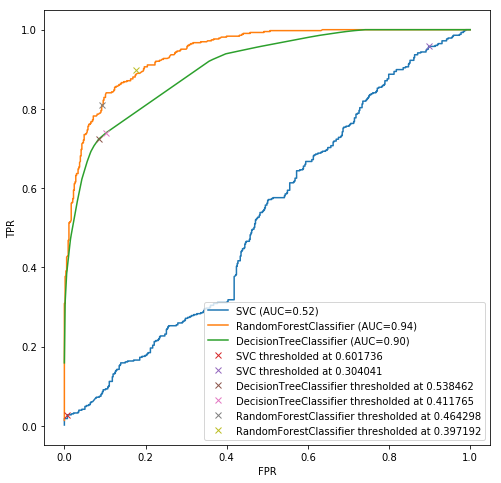

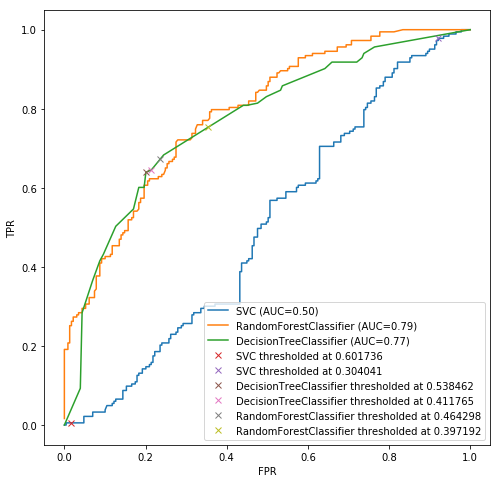

In [80]:
roc_plot([svm_tuned,rf_tuned,dt_tuned],[svm_opt_acc,svm_opt_f1,dt_opt_acc,dt_opt_f1,rf_opt_acc,rf_opt_f1],X_train,y_train)
roc_plot([svm_tuned,rf_tuned,dt_tuned],[svm_opt_acc,svm_opt_f1,dt_opt_acc,dt_opt_f1,rf_opt_acc,rf_opt_f1],X_test,y_test)

**<font color='purple'>Answer to (p):</font>**  No model is dominating over any other.The ROC curves is representing more accuracy in train then test data.

## Task 2: Logistic regression (4 points)

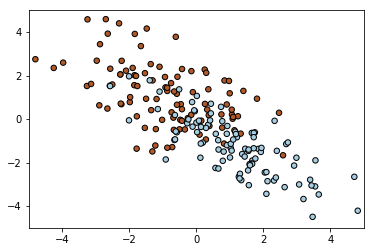

In [121]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def create_synthetic_data(n_instances):
    n_positives = round(n_instances/2)
    n_negatives = n_instances - n_positives
    X = np.zeros((n_instances,2))
    X[:n_positives,:] = np.random.multivariate_normal((-1,+1),((2,-1),(-1,2)),n_positives)
    X[n_positives:,:] = np.random.multivariate_normal((+1,-1),((2,-1.5),(-1.5,2)),n_negatives)
    Y = n_positives*[1]+n_negatives*[0]
    return(X,Y)

np.random.seed(0)
train_X, train_Y = create_synthetic_data(200)
test_X, test_Y = create_synthetic_data(20000)

plt.scatter(train_X[:, 0], train_X[:, 1], s=30, c=train_Y, cmap=plt.cm.Paired, edgecolors='k')
plt.axis([-5, 5, -5, 5])
plt.show()

- **(a)** Implement logistic regression using gradient descent of cross entropy. For this look up the formula for cross entropy and its gradient formulas from the lecture slides. Print out the final weights and bias term. Print out the number of iterations that the algorithm ran.  

**<font color='red'>(a) Your implementation, prints out the final weights and bias term and the number of iterations:</font>**

- **(b)** Supplement each iteration of your above implementation with the calculation of cross entropy on the training data and on the test data. Make a plot with iteration number on the x-axis and cross entropy on the y-axis, with training and test loss shown in different colour. Discuss if you see signs of overfitting.

**<font color='red'>(b) Your implementation making the plot:</font>**

**<font color='red'>Discuss if you see signs of overfitting:</font>**

- **(c)** Compare your learned weights and bias term to those obtained from sklearn implementation of logistic regression (sklearn.linear_model.LogisticRegression). Please use the parameter C value `C=1e10` (this is needed as by default sklearn logistic regression uses regularisation). Print out the final weights and bias term. Print out the differences from what your implementation found (subtract sklearn weights and bias from your weights and bias, respectively, and print out). The coefficients from sklearn implementation and your implementation must not differ by more than 0.001 (if they do then please check your code and possibly run more iterations or adjust the learning rate). 

**<font color='red'>(c) Your code to print the model learned with sklearn implementation of logistic regression and its difference from yours:</font>**

In [100]:
from sklearn.linear_model import LogisticRegression
def_logistic_regression = LogisticRegression(C=1e10).fit(train_X, train_Y)
print(def_logistic_regression.intercept_)
print(def_logistic_regression.coef_ )
print(def_logistic_regression.n_iter_)

[0.17501417]
[[-0.44153367  1.03308397]]
[5]


- **(d)** Implement logistic regression using **stochastic** gradient descent of cross entropy. Print out the final weights and bias term. Print out the differences in weights and bias between this implementation and sklearn logistic regression (sklearn.linear_model.LogisticRegression, same as in subtask (c)). The coefficients from sklearn implementation and your implementation must not differ by more than 0.001 (if they do then please check your code and possibly run more iterations or adjust the learning rate). 

**<font color='red'>(d) Your implementation, prints out the final weights and bias term and the number of iterations, prints out the differences between your implementation and sklearn:</font>**

In [106]:
from sklearn import linear_model
def_SGD = linear_model.SGDRegressor()
fit_SGD = def_SGD.fit(train_X, train_Y)
print(fit_SGD.intercept_, fit_SGD.coef_, fit_SGD.n_iter_)

[0.46892719] [-0.06016568  0.13459978] 5


- **(e)** About your stochastic gradient descent implementation make the same plot as you did in subtask **(b)** about gradient descent (cross entropy on train and test at each iteration). Discuss if you see signs of overfitting. Discuss the differences of plots about gradient descent and stochastic gradient descent.

**<font color='red'>Your implementation making the plot:</font>**

**<font color='red'>Discuss if you see signs of overfitting:</font>**

**<font color='red'>Discuss the differences of plots about gradient descent and stochastic gradient descent:</font>**

- **(f)** Calculate and report accuracy of the logistic regression model on the test data. Do this on the model learned with sklearn in subtask **(c)**. 

**<font color='red'>(f) Your implementation reporting accuracy:</font>**

In [105]:
print(accuracy_score(test_Y, def_logistic_regression.predict(test_X)))

0.7776


- **(g)** Since we have generated the data ourselves with balanced classes drawn from two Gaussian distributions, we know what the optimal classifier is. The optimal classifier must predict positive whenever the likelihood of the positive class is higher than the likelihood of the negative class (as the class priors are equal, comparing the likelihoods is sufficient). For each test instance calculate these likelihoods and then calculate the accuracy of the optimal classifier on the test data (this classifier is known as the Bayes-optimal classifier). 

**<font color='red'>(g) Add to the following implementation and print accuracy of the Bayes-optimal classifier:</font>**

In [118]:
from scipy.stats import multivariate_normal
pos_likelihood_func = multivariate_normal(mean=(-1,+1), cov=((2,-1),(-1,2))).pdf
neg_likelihood_func = multivariate_normal(mean=(+1,-1), cov=((2,-1.5),(-1.5,2))).pdf

# Example usage:
print(pos_likelihood_func(test_X))
print(neg_likelihood_func(test_X))

# add your code here
predictions = []
pos_likelihood = pos_likelihood_func(test_X)
neg_likelihood = neg_likelihood_func(test_X)
for x in range(len(pos_likelihood)):
    if pos_likelihood[x] > neg_likelihood[x]:
      predictions.append(1)
    else:
      predictions.append(0)
print (accuracy_score(test_Y,predictions))

[0.0412135  0.06427775 0.01805684 ... 0.0016481  0.09175873 0.00258289]
[0.02189665 0.00898235 0.1051964  ... 0.02608249 0.03792818 0.07491848]
0.7926


- **(h)** Learn a SVM model with RBF kernel with default parameters and report the accuracy on the test data.

**<font color='red'>(h) Your implementation reporting test accuracy of SVM:</font>**

In [92]:
from sklearn import svm
svm_model = svm.SVC()

# add your code here
svm_model.fit(train_X,train_Y)
predict = svm_model.predict(test_X)
acc = accuracy_score(test_Y,predict)
print(acc)

0.77905


- **(i)** Draw the decision boundaries of the logistic regression model learned in **(c)**, SVM model learned in **(h)** and the Bayes-optimal model (explained in **(g)**). Discuss whether logistic regression or SVM learned a better model and explain why.

**<font color='red'>Fill the gaps in the following code:</font>**

In [94]:
def make_plots(lr_model,svm_model):
    x1, x2 = np.meshgrid(np.linspace(-5, 5, 500),np.linspace(-5, 5, 500))   
    xx = np.c_[x1.ravel(), x2.ravel()]
    opt_pred = np.sign(pos_likelihood_func(xx)/(pos_likelihood_func(xx)+neg_likelihood_func(xx))-0.5)
    opt_pred = opt_pred.reshape(x1.shape)

    lr_pred = np.sign(lr_model.predict(xx)-0.5).reshape(x1.shape)
    svm_pred = np.sign(svm_model.predict(xx)-0.5).reshape(x1.shape)
    
    fig, axes = plt.subplots(1,3,figsize=(15,5))
    for i in range(3):
        pred = [lr_pred,svm_pred,opt_pred][i]
        ax = axes[i]
        ax.imshow(pred, interpolation='nearest',
                  extent=(x1.min(), x1.max(), x2.min(), x2.max()), aspect='auto',
                  origin='lower', cmap=plt.cm.PuOr_r)
        contours = ax.contour(x1, x2, pred, levels=[0], linewidths=2)
        ax.scatter(train_X[:, 0], train_X[:, 1], s=30, c=train_Y, cmap=plt.cm.Paired,
                    edgecolors='k')
        ax.axis([-5, 5, -5, 5])
    plt.show()
    
lr_model = def_logistic_regression
svm_model = svm_model
make_plots(lr_model,svm_model)

**<font color='red'>Discuss whether logistic regression or SVM learned a better model and explain why:</font>** logistic regression learned a better model, because it makes use of one or more predictor variables that may be either continuous or categorical.

- **(j)** Use the logistic regression model from subtask **(c)** to obtain class probability estimates on the test data (note that you can easily do **(c)** even if you did not solve **(a)** and **(b)**). Evaluate these probabilities with cross entropy with respect to the actual class. For this implement a function calculating cross entropy. Report the value of cross entropy.

**<font color='red'>Fill the gaps in the following code and report cross entropy:</font>**

In [110]:
lr_model = def_logistic_regression
class_prob_estimates = lr_model.predict_proba(test_X)
print(class_prob_estimates[:10,:])

def cross_entropy(predicted_probabilities,actual_classes):
    en = 0
    for x in range(len(actual_classes)):
        en = en + (-1 * actual_classes[x]*np.log2(predicted_probabilities[x][0]) - (1- actual_classes[x])*np.log2(predicted_probabilities[x][1]))
    result = en/len(predicted_probabilities) 
    return(result)

print(cross_entropy(class_prob_estimates,test_Y))

[[0.47460265 0.52539735]
 [0.03979971 0.96020029]
 [0.80150196 0.19849804]
 [0.04127579 0.95872421]
 [0.27337052 0.72662948]
 [0.65205802 0.34794198]
 [0.27018086 0.72981914]
 [0.00627244 0.99372756]
 [0.08480552 0.91519448]
 [0.00597562 0.99402438]]
2.8063340727890025


- **(k)** Apply Platt scaling (also called logistic calibration) on the SVM model from **(h)**. Evaluate the resulting probabilities with cross entropy and report the result.

**<font color='red'>Fill the gaps in the following code and report cross entropy:</font>**

In [111]:
from sklearn.calibration import CalibratedClassifierCV

svm_cal = CalibratedClassifierCV(svm_model, cv=2, method='sigmoid')
svm_cal.fit(train_X, train_Y)
svm_cal_prob = svm_cal.predict_proba(test_X)

# calculate and print cross entropy on the predicted probabilities
print(cross_entropy(svm_cal_prob,test_Y))

2.0315411674730903


- **(l)** Draw the 0.25-, 0.5- and 0.75-probability lines (also called iso-lines) of the logistic regression model, calibrated SVM model and the Bayes-optimal model. Discuss whether better class probability estimates were obtained from logistic regression or from SVM after calibrating with Platt scaling. Explain why.

**<font color='red'>Fill the gaps in the following code:</font>**

In [113]:
def make_prob_plots(lr_model,svm_cal_model):
    x1, x2 = np.meshgrid(np.linspace(-5, 5, 500),np.linspace(-5, 5, 500))   
    xx = np.c_[x1.ravel(), x2.ravel()]
    opt_pred = pos_likelihood_func(xx)/(pos_likelihood_func(xx)+neg_likelihood_func(xx))
    opt_pred = opt_pred.reshape(x1.shape)

    lr_pred = lr_model.predict_proba(xx)[:,1].reshape(x1.shape)
    svm_cal_pred = svm_cal_model.predict_proba(xx)[:,1].reshape(x1.shape)
    
    fig, axes = plt.subplots(1,3,figsize=(15,5))
    for i in range(3):
        pred = [lr_pred,svm_cal_pred,opt_pred][i]
        ax = axes[i]
        ax.imshow(pred, interpolation='nearest',
                  extent=(x1.min(), x1.max(), x2.min(), x2.max()), aspect='auto',
                  origin='lower', cmap=plt.cm.PuOr_r)
        contours = ax.contour(x1, x2, pred, levels=[0.25,0.5,0.75], linewidths=2)
        ax.scatter(train_X[:, 0], train_X[:, 1], s=30, c=train_Y, cmap=plt.cm.Paired,
                    edgecolors='k')
        ax.axis([-5, 5, -5, 5])
    plt.show()
    
lr_model = def_logistic_regression
svm_cal_model = svm_cal
make_prob_plots(lr_model,svm_cal_model)

**<font color='red'>Discuss whether better class probability estimates were obtained from logistic regression or from SVM after calibrating with Platt scaling. Explain why:</font>**
SVM after calibrating with Platt scaling is better. Because calibration use ‘sigmoid’ method.

 ## How long did it take you to solve the homework?

Please answer as precisely as you can. It does not affect your points or grade in any way. It is okey, if it took 30 minutes or 24 hours. The results are used to improve the homeworks next year.

**<font color='red'>Task 1:</font>** 8 hours 

**<font color='red'>Task 2:</font>** 

**<font color='red'>In total:</font>** 

<font color='red'>Please use <b>"Kernel->Restart and Run All"</b> command in Jupyter Notebook before submitting the homework and check your results. This ensures that we would be able to replicate your results while grading.</font>